# Лабораторная курса Deep Learning
## Выполнил студент: Гумеров Булат (gumaonelove)

## Подготовка

### Импорты

In [ ]:
import cv2
import os
import torch
import torchvision
import random


import pandas as pd
import numpy as np
import pickle as pkl


from evaluate import load
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn

In [ ]:
!pip install evaluate jiwer


### Подключение GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Фиксирование рандома

In [ ]:
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
device

## Загрузка Датасета

### Токенизация

#### Получите список автомобильных номеров

In [ ]:
def exec_text(path):
    return path[path.find('-') + 1:path.find('.')]

input_dir_train = './CCPD2019-dl1/train'

car_numbers = [exec_text(path) for  path in os.listdir(input_dir_train)]

#### Получите алфавит символов из всех автомобильных номеров

In [ ]:
seq = ''
for car_number in car_numbers:
    seq += car_number
alphabet = ''
for symbol in sorted(set(seq)):
    alphabet += symbol
alphabet    

'0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ云京冀吉宁川新晋桂沪津浙渝湘琼甘皖粤苏蒙藏豫贵赣辽鄂闽陕青鲁黑'

#### Константы

In [ ]:
OOV_TOKEN = '<OOV>' # отсутствует лексема из словаря
CTC_BLANK = '<BLANK>' # токен для матрицы ctc
PAD_TOKEN = '<PAD>' # заполняющий токен
batch_size = 128

#### Создание из строкового алфавита символ dict(int)

In [ ]:
def get_char_map(alphabet):
    """
    Добавьте пустую диаграмму для потери CTC и символ OOV для 
    символов, не входящих в словарный запас.
    """
    char_map = {value: idx + 3 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    char_map[PAD_TOKEN] = 2
    return char_map

#### Класс для кодирования и декодирования

In [ ]:
class Tokenizer:
    """""Класс для кодирования и декодирования строкового слова в 
    интересующую последовательность (и наоборот) с использованием алфавита."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [ ]:
tokenizer = Tokenizer(alphabet)

In [ ]:
class Laba_dataset(torch.utils.data.Dataset):
    def __init__(self, root, tokenizer, transform=None):
        self.root = root
        self.transform = transform
        self.tokenizer = tokenizer
        self.img_paths = [os.path.join(self.root, img_path) for img_path in os.listdir(self.root)]
        self.text = [exec_text(path) for path in os.listdir(self.root)]
        self.enc_text = self.tokenizer.encode(self.text)
    
    def __getitem__(self, ind):
        img = Image.open(self.img_paths[ind]) # resize
        if self.transform is not None:
            img = self.transform(img) # make some augmentations
        # return image, encoded_text, source_text
        return (img, torch.LongTensor(self.enc_text[ind]), self.text[ind])

    def __len__(self):
        return len(self.img_paths)

In [ ]:
def collate_fn(batch):
    images, enc_texts, texts = zip(*batch)
    images = torch.stack(images, 0)
    enc_pad_texts = torch.nn.utils.rnn.pad_sequence(enc_texts, batch_first=True, padding_value=tokenizer.char_map[PAD_TOKEN])
    return images, enc_pad_texts, texts

#### Некоторые дополнения для регуляризации модели

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 128)),
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.GaussianBlur(3),
    torchvision.transforms.ToTensor()
])

### Создание Датасета

In [ ]:
dataset_full = Laba_dataset(input_dir_train, tokenizer, transform=transform)

#### Разделение на обучающую и валидационную выборку

In [ ]:
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.9)

#### Инициализация Датасата

In [ ]:
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

In [ ]:
dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}

#### Создание DataLoader

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=8
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=8
    ),
}

In [ ]:
input_dir_test = './CCPD2019-dl1/test'
batch_size = 64
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 128)),
    torchvision.transforms.ToTensor()
        ])
dataset_test = Laba_dataset(input_dir_test, tokenizer, transform=transform_test)
dataloader_test = torch.utils.data.DataLoader(
        dataset=dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )

In [ ]:
next(iter(dataloader['train']))[0].shape

torch.Size([128, 3, 32, 128])

### Откроем на случайное изображение

In [ ]:
img = torchvision.transforms.ToPILImage()(dataset_full[173][0].squeeze(0)) # take a look to random image

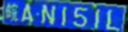

In [ ]:
img

In [ ]:
dataset_test[122] # take a look to element from dataset

## Создание модели

Чтобы решить проблему, я использую структуру CRNN

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, dropout=0.15):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, 1, stride=2)
        
    def forward(self, x, identity=True):
        out = self.dropout(self.bn(self.conv(x)))
        if identity:
            if self.downsample is not None:
                x = self.downsample(x)
            return self.relu(out + x)
        else: 
            return self.relu(out)

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_layers=2, dropout=0.1):
        super().__init__()
        """
        В качестве средства извлечения объектов я использую resnet, при прохождении через cut изображения
        преобразуются из dimension tensor (C: 1, W: 128, H: 32) to the 
        dimension tensor (C: 1, W: 4, H: 1)
        """
        self.start = ResNetBlock(3, 64, 7, 1, 0, 0.0)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.blocks1 = nn.ModuleList([ResNetBlock(64, 64, padding=1) for _ in range(num_layers)])
        self.blocks2 = nn.ModuleList([ResNetBlock(64, 128, padding=1, stride=2)] + [ResNetBlock(128, 128, padding=1) for _ in range(num_layers)])
        self.blocks3 = nn.ModuleList([ResNetBlock(128, 256, padding=1, stride=2)] + [ResNetBlock(256, 256, padding=1) for _ in range(num_layers)])
        self.blocks4 = nn.ModuleList([ResNetBlock(256, 512, padding=1, stride=2)] + [ResNetBlock(512, 512, padding=1) for _ in range(num_layers)])
        self.blocks5 = nn.ModuleList([ResNetBlock(512, 1024, padding=1, stride=2)] + [ResNetBlock(1024, 1024, padding=1) for _ in range(num_layers)])
        self.blocks = [self.blocks1, self.blocks2, self.blocks3, self.blocks4, self.blocks5]
        
    def forward(self, x):
        out = self.maxpool(self.start(x, identity=False))
        for blocks in self.blocks:
            for block in blocks:
                out = block(out)

        return out

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

5 блоков ResNet, 3 BiLSTM, линейный классификатор
для того, чтобы модель могла идентифицировать более сложные
зависимости в данных, поскольку набор данных позволяет ввести
глубокую нейронную сеть

In [ ]:
class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=3,
    ):
        super().__init__()
        self.feature_extractor = CNN(dropout=0.15)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len, dropout=0.15)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(time_feature_count, number_class_symbols) # the model predicts the probability of characters from the alphabet
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)

        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

### Определим показатель точности для оценки валидационной выборки

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

## Обучение модели

### Функции для сохранения модели

In [ ]:
def safe(obj, filename):
    with open(filename, 'wb') as outp:
        pkl.dump(obj, outp)

In [ ]:
def read(filename):
    with open(filename, 'rb') as inp:
        return pkl.load(inp)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    for images, enc_texts, texts in data_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    return acc_avg.avg

In [ ]:
def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds

In [ ]:
def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, enc_texts, texts in data_loader:
        model.zero_grad()
        images = images.to(device)
        batch_size = len(texts)
        output = model(images)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        text_lens = torch.LongTensor([len(text) for text in texts]) # for CTC-loss
        loss = criterion(output, enc_texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg

In [ ]:
accs = {}

In [ ]:
def train(dataloader, epochs, trained_model=None, trained_model_epochs=0):
    train_loader, val_loader = dataloader['train'], dataloader['valid']
    if trained_model == None:
        model = CRNN(number_class_symbols=tokenizer.get_num_chars())
        model.apply(weights_init)
        model.to(device)
    else:
        model = trained_model

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.5, patience=5)
    best_acc = -np.inf
    acc_avg = val_loop(val_loader, model, tokenizer, device)
    for epoch in range(epochs):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, device)
        accs[acc_avg] = epoch
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
        if trained_model_epochs == 0:
            safe(model, f'model_{epoch}')
        else:
            safe(model, f'model_{epoch + trained_model_epochs}')

In [ ]:
train(dataloader, 8)

Validation, acc: 0.0000

Epoch 0, Loss: 1.68883, LR: 0.0010000
Validation, acc: 0.3340

Epoch 1, Loss: 0.23575, LR: 0.0010000
Validation, acc: 0.6538

Epoch 2, Loss: 0.10533, LR: 0.0010000
Validation, acc: 0.9317

Epoch 3, Loss: 0.05218, LR: 0.0010000
Validation, acc: 0.9395

Epoch 4, Loss: 0.04142, LR: 0.0010000
Validation, acc: 0.9573

Epoch 5, Loss: 0.03328, LR: 0.0010000
Validation, acc: 0.9699

Epoch 6, Loss: 0.02488, LR: 0.0010000
Validation, acc: 0.9650

Epoch 7, Loss: 0.02500, LR: 0.0010000
Validation, acc: 0.9668


### Загрузим модель с наилучшими результатами проверки

In [ ]:
model = read(f'./model_{accs[max(accs.keys())]}')

### Дообучим модель

In [ ]:
train(dataloader, 10, model, 8) # more epochs

Validation, acc: 0.9684

Epoch 0, Loss: 0.02766, LR: 0.0010000
Validation, acc: 0.9715

Epoch 1, Loss: 0.02236, LR: 0.0010000
Validation, acc: 0.9669

Epoch 2, Loss: 0.01953, LR: 0.0010000
Validation, acc: 0.9771

Epoch 3, Loss: 0.01721, LR: 0.0010000
Validation, acc: 0.9784

Epoch 4, Loss: 0.01611, LR: 0.0010000
Validation, acc: 0.9821

Epoch 5, Loss: 0.01570, LR: 0.0010000
Validation, acc: 0.9808

Epoch 6, Loss: 0.01318, LR: 0.0010000
Validation, acc: 0.9733

Epoch 7, Loss: 0.01456, LR: 0.0010000
Validation, acc: 0.9831

Epoch 8, Loss: 0.01173, LR: 0.0010000
Validation, acc: 0.9848

Epoch 9, Loss: 0.01146, LR: 0.0010000
Validation, acc: 0.9827


In [ ]:
img, enc_label, label = dataset_full[2001]

In [ ]:
model = read(f'./model_{16}') # take model with the best acc on validation

In [ ]:
pred = predict(img.unsqueeze(0).to(device), model, tokenizer, device) # sample pred
pred

['皖KLJ029']

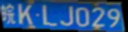

In [ ]:
real_img = torchvision.transforms.ToPILImage()(img)
real_img

## Оценим результаты

CER = (S + D + I) / N = (S + D + I) / (S + D + C), где

* S - количество замен, 
* D - количество удалений, 
* I - количество вставок, 
* C - количество правильных символов, 
* N - количество символов в ссылке (N=S+D+C).

In [ ]:
cer = load("cer")

In [ ]:
references = dataset_test.text

In [ ]:
predictions = []
for imgs, enc_text, text in dataloader_test:
    predictions += predict(imgs, model, tokenizer, device)

In [ ]:
cer.compute(predictions=predictions, references=references)

0.0058005800580058

Выходные данные CER не всегда представляют собой число от 0 до 1, особенно при большом количестве вставок. 

Это значение часто связано с процентом символов, которые были неправильно предсказаны. Чем ниже значение, тем выше производительность системы ASR, при этом CER, равный 0, является идеальной оценкой.

In [ ]:
len(references) == len(predictions)

True

In [ ]:
errors = {} # dict of errors {predictions: references}
for pred, refer in zip(predictions, references):
    if cer.compute(predictions=[pred], references=[refer]) != 0.0:
        errors[pred] = refer

In [ ]:
errors

Как мы видим, модель больше всего ошибается в китайских иероглифах, я попытался исправить это с помощью дополнений, но все равно есть цифры, в которых модель неверна. Эти ошибки, скорее всего, возникают из-за плохого качества изображения, это также можно исправить, расширив выборку или обучив модель специально распознаванию китайских иероглифов, а затем объединив ее с основной моделью. Кроме того, модель иногда допускает ошибки в длине номера и в средних символах. Это можно исправить с помощью дополнений: например, закрасив какую-то часть определенного символа.

In [ ]:
key_err_0 = list(errors.values())[0]

In [ ]:
ind_err_0 = dataset_test.text.index(key_err_0)

Ошибки также могут быть вызваны повреждением чисел, что мы видим в этом примере

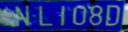

In [ ]:
torchvision.transforms.ToPILImage()(dataset_test[ind_err_0][0])

In [ ]:
list(errors.keys())[0]

'皖HL108D'

In [ ]:
key_err_0 

'皖NL108D'

In [ ]:
acc_avg = val_loop(dataloader_test, model, tokenizer, device)

Validation, acc: 0.9667


In [ ]:
acc_avg

0.9666966696669667

## Итоговые результаты

Accuracy on test: 0.9666966696669667

CER on test: 0.0058005800580058